In [9]:
# PINN for moving lid problem

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from pyDOE3 import lhs  # For Latin Hypercube Sampling

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Creating the mesh just like fenics as a 1by1 square with triangle mesh
#outfile_vel = "C:xxxxxxxxxxxxxxxxxxxxxxxxxxxx\\u_PINN_moving_lid_test.txt"
#outfile_pres = "C:xxxxxxxxxxxxxxxxxxxxxxxxxxx\\p_PINN_moving_lid_test.txt"
N1, N2, N3, N4, N5, N6 = 114, 436, 1642, 6381, 25315, 100266
N = N3

# Inflow points
I1, I2, I3, I4, I5, I6 = N1/7, N2/7, N3/7, N4/7, N5/7, N6/7
I = int(N/7)
x = np.linspace(0, 1, N + 1)
y = np.linspace(0, 1, N + 1)

xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T  # Shape: [(N+1)^2, 2]

In [12]:
# Setting the boundary conditions
num_samples = N  # total number of points to sample
points = lhs(2, samples=num_samples)  # samples in [0,1]^2
tol = 0.05  # Numerical tolerance for boundary detection

# Classify points
boundary_points = []
top_boundary_pts = []
other_walls_pts = []

for i, (x, y) in enumerate(points):
    on_boundary = (abs(x - 0.0) < tol or abs(x - 1.0) < tol or
                   abs(y - 0.0) < tol or abs(y - 1.0) < tol)
    if on_boundary:
        boundary_points.append(i)
        if abs(y - 1.0) < tol:
            top_boundary_pts.append(i)  # Top lid
        else:
            other_walls_pts.append(i)   # Left, bottom, right

# Setting the indices
boundary_indices = set(top_boundary_pts + other_walls_pts)
all_indices = set(range(len(points)))
interior_indices = list(all_indices - boundary_indices)

# Convert to numpy arrays
interior_indices = np.array(interior_indices)
boundary_indices = np.array(list(boundary_indices))
points_interior = points[interior_indices]
points_boundary = points[boundary_indices]

# Convert to torch tensors
points_interior = torch.tensor(points_interior, dtype=torch.float32)
points_boundary = torch.tensor(points_boundary, dtype=torch.float32)

In [13]:
# Define the Stokes PINN model
class StokesPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 32)
        self.layer5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))
        return self.output_layer(x)  # [u, v, p]
    
model = StokesPINN()

In [14]:
epsilon = 0.001
# Ensure input has gradients enabled
def gradients(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u

def compute_residuals(model, x, mu):
    x.requires_grad_(True)
    output = model(x)
    u, v, p = output[:, 0], output[:, 1], output[:, 2]

    # First-order derivatives
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y = grad_u[:, 0], grad_u[:, 1]

    grad_v = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y = grad_v[:, 0], grad_v[:, 1]

    grad_p = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y = grad_p[:, 0], grad_p[:, 1]

    # Second-order derivatives (Laplacians)
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y, x, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1]

    # PDE residuals (Stokes equations: -Δu + ∇p = f)
    f1 = p_x - mu*(u_xx + u_yy)
    f2 = p_y - mu*(v_xx + v_yy)
    div_u = u_x + v_y 

    return f1, f2, div_u


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
mu = 1.0

for epoch in range(3000):
    optimizer.zero_grad()
    # Compute the pde residuals
    f1, f2, div = compute_residuals(model, points_interior, mu)
    loss_f = (f1**2).mean() + (f2**2).mean() + 1*(div**2).mean()
    
    # Separate top and other wall boundary tensors
    top_boundary_tensor = torch.tensor(points[top_boundary_pts], dtype=torch.float32)
    other_walls_tensor = torch.tensor(points[other_walls_pts], dtype=torch.float32)

    # Predictions on boundary
    output_top = model(top_boundary_tensor)
    u_top = output_top[:, 0]
    v_top = output_top[:, 1]

    output_wall = model(other_walls_tensor)
    u_wall = output_wall[:, 0]
    v_wall = output_wall[:, 1]

    # Boundary losses (MSE)
    loss_top = ((u_top - 1.0) ** 2).mean() + ((v_top - 0.0) ** 2).mean()
    loss_wall = ((u_wall - 0.0) ** 2).mean() + ((v_wall - 0.0) ** 2).mean()
    loss_bc = loss_top + 1*loss_wall

    # Pressure normalization 
    output_interior = model(points_interior)
    p_interior = output_interior[:, 2]  
    pressure_average = (p_interior.mean())**2

    loss = loss_f + 1*loss_bc + 1*pressure_average
    loss.backward()
    optimizer.step()
    losses.append(loss.item()**2)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 1.004297
Epoch 100: Loss = 0.146009
Epoch 200: Loss = 0.135173
Epoch 300: Loss = 0.125064
Epoch 400: Loss = 0.108009
Epoch 500: Loss = 0.095085
Epoch 600: Loss = 0.082742
Epoch 700: Loss = 0.076615
Epoch 800: Loss = 0.070038
Epoch 900: Loss = 0.065964
Epoch 1000: Loss = 0.063525
Epoch 1100: Loss = 0.061196
Epoch 1200: Loss = 0.059880
Epoch 1300: Loss = 0.064683
Epoch 1400: Loss = 0.057805
Epoch 1500: Loss = 0.057079
Epoch 1600: Loss = 0.056398
Epoch 1700: Loss = 0.055671
Epoch 1800: Loss = 0.055792
Epoch 1900: Loss = 0.054608
Epoch 2000: Loss = 0.054048
Epoch 2100: Loss = 0.054121
Epoch 2200: Loss = 0.053230
Epoch 2300: Loss = 0.053719
Epoch 2400: Loss = 0.052811
Epoch 2500: Loss = 0.052274
Epoch 2600: Loss = 0.055880
Epoch 2700: Loss = 0.051773
Epoch 2800: Loss = 0.051623
Epoch 2900: Loss = 0.051356


Locator attempting to generate 8420 ticks ([-0.14970000000000003, ..., 1.11315]), which exceeds Locator.MAXTICKS (1000).


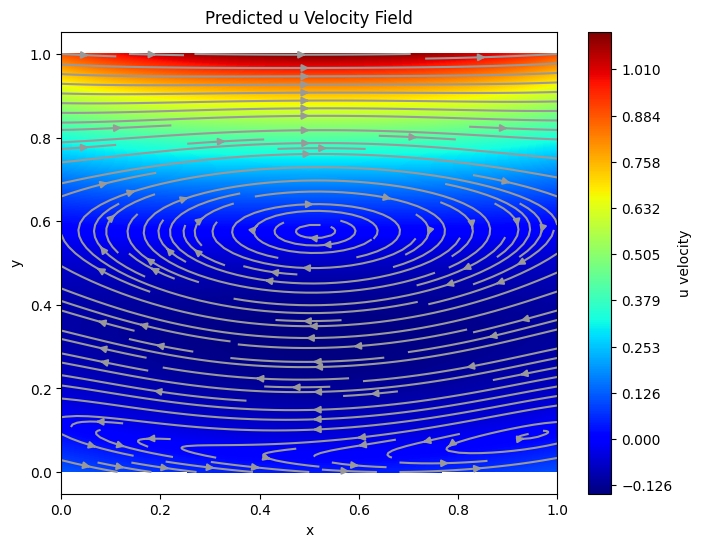

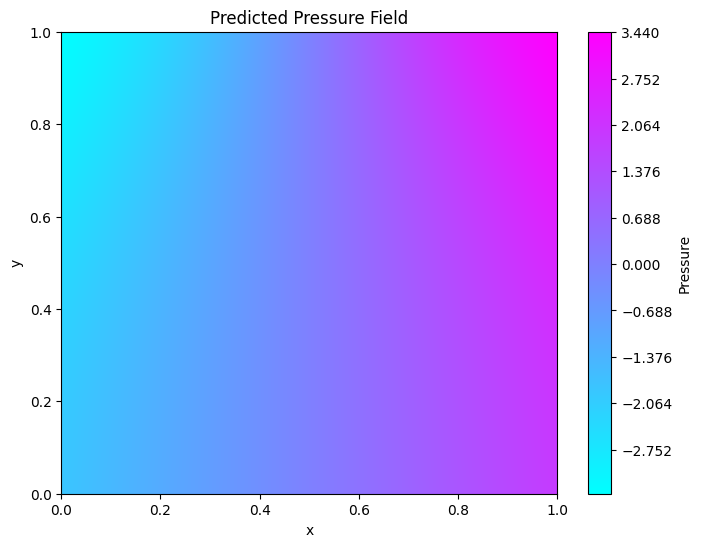

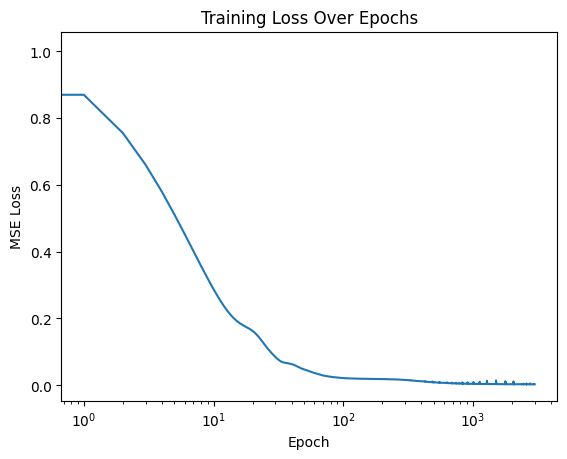

In [16]:
# Improved visualization with gradient color maps
with torch.no_grad():
    x_plot, y_plot = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    coords_plot = torch.tensor(np.column_stack((x_plot.ravel(), y_plot.ravel())), dtype=torch.float32).to(device)
    outputs = model(coords_plot)
    u_pred = outputs[:, 0].cpu().numpy().reshape(100, 100)
    v_pred = outputs[:, 1].cpu().numpy().reshape(100, 100)
    p_pred = outputs[:, 2].cpu().numpy().reshape(100, 100)

    # Plot u velocity field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.streamplot(x_plot, y_plot, u_pred, v_pred, density=1.5, color=(0.6, 0.6, 0.6))
    contour = ax.contourf(x_plot, y_plot, u_pred, levels=10000, cmap='jet')  # Increased levels for smoother gradients
    plt.colorbar(contour, label="u velocity")
    ax.set_title("Predicted u Velocity Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
    
    # Plot pressure field with gradient colors
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(x_plot, y_plot, p_pred, levels=1000, cmap='cool')  # Increased levels for smoother gradients
    plt.colorbar(contour, label="Pressure")
    ax.set_title("Predicted Pressure Field")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()
   
    # plotting the loss
    plt.figure()
    plt.plot(losses)
    plt.xscale('log') 
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

    # Build a regular grid 
    n_axis = 64 
    xs = np.linspace(0.0, 1.0, n_axis)
    ys = np.linspace(0.0, 1.0, n_axis)
    x_grid, y_grid = np.meshgrid(xs, ys)          

    # Stack into tensor 
    coords_81 = torch.tensor(np.column_stack((x_grid.ravel(), y_grid.ravel())),dtype=torch.float32,device=device)

    # Evaluate the network at those points
    with torch.no_grad():
        pred = model(coords_81)        
        u_eval = pred[:, 0].cpu().numpy() #
        v_eval = pred[:, 1].cpu().numpy() # 
        p_eval = pred[:, 2].cpu().numpy() # 

    u_grid = u_eval.reshape(n_axis, n_axis)
    v_grid = v_eval.reshape(n_axis, n_axis)
    p_grid = p_eval.reshape(n_axis, n_axis)


    #Save to a text file
    #np.savetxt(outfile_vel,u_eval,fmt="%.7f",comments="")
    #np.savetxt(outfile_pres,p_eval,fmt="%.7f",comments="")